<a href="https://colab.research.google.com/github/Mafaz03/Model/blob/main/Proximity_simulation_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1 Importing Dependencies

In [5]:
#Dependencies related to predictions and visualization
import torch
import cv2 as cv
import matplotlib.pyplot as plt
import time
import numpy as np
from google.colab.patches import cv2_imshow

In [6]:
#Dependencies related to files
import os
from pathlib import Path
import requests
import zipfile

In [22]:
#Supporting module
import time
try:
  import timm
except:
  !pip install timm -q
  import timm

In [8]:
#Setting device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

#2 Setting MiDaS

In [10]:
#Imorting large midas model and small midas model
model_type_large = "DPT_Large"
model_type_small = "MiDaS_small"

midas_large = torch.hub.load("intel-isl/MiDaS" , model_type_large)
midas_small = torch.hub.load("intel-isl/MiDaS" , model_type_small)

midas_large.to(device)
midas_small.to(device)

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


/usr/local/lib/python3.10/dist-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/rwightman/gen-efficientnet-pytorch/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_lite3-b733e338.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_lite3-b733e338.pth
Downloading: "https://github.

MidasNet_small(
  (pretrained): Module(
    (layer1): Sequential(
      (0): Conv2dSameExport(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
      (3): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act1): ReLU6(inplace=True)
          (se): Identity()
          (conv_pw): Conv2d(32, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act2): Identity()
        )
      )
      (4): Sequential(
        (0): InvertedResidual(
          (conv_pw): Conv2d(24, 144, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(144,

In [11]:
#importing large and small transforms for midas
midas_transforms = torch.hub.load("intel-isl/MiDaS" , "transforms")

transforms_large = midas_transforms.dpt_transform
transform_small = midas_transforms.small_transform

transforms_large , transform_small

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


(Compose(
     <function transforms.<locals>.<lambda> at 0x7fe2f304ab90>
     <function transforms.<locals>.<lambda> at 0x7fe2f304acb0>
 ),
 Compose(
     <function transforms.<locals>.<lambda> at 0x7fe2f304b7f0>
     <function transforms.<locals>.<lambda> at 0x7fe2f304a830>
 ))

#3 Downloading test images

In [16]:
data_path = Path("data/")
image_path = data_path / "test_images" #images gets stored here

image_path.mkdir(parents = True , exist_ok = True)

with open(data_path / "test_images.zip" , "wb") as f:
  req = requests.get("https://github.com/Mafaz03/Datasets/raw/main/Midas_comparison/Test_images.zip")
  f.write(req.content)

with zipfile.ZipFile(data_path / "test_images.zip") as zip:
  zip.extractall(image_path)

In [17]:
workbench = cv.imread("/content/data/test_images/Workbench.png")
eeve = cv.imread("/content/data/test_images/eeve.png")
cycle = cv.imread("/content/data/test_images/Cycle.png")

workbench = cv.cvtColor(workbench, cv.COLOR_BGR2RGB)
eeve = cv.cvtColor(eeve, cv.COLOR_BGR2RGB)
cycle = cv.cvtColor(cycle, cv.COLOR_BGR2RGB)

size = cycle.shape[:2]

#3.1 Plotting test images

(-0.5, 1919.5, 1079.5, -0.5)

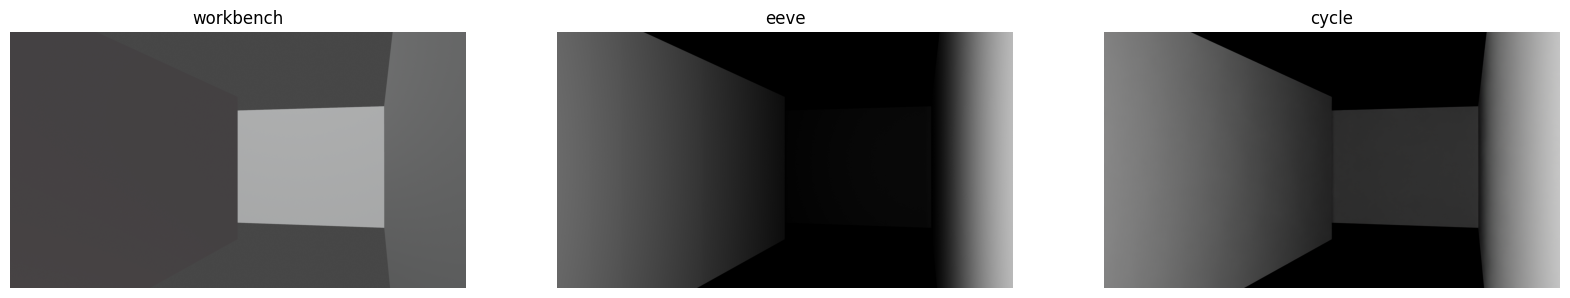

In [18]:
plt.figure(figsize = (20,20))

plt.subplot(1,3,1)
plt.imshow(workbench)
plt.title("workbench")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(eeve)
plt.title("eeve")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(cycle)
plt.title("cycle")
plt.axis("off")


#4 Applying transforms

In [20]:
workbench_transformed_large = transforms_large(workbench).to(device)
eeve_transformed_large = transforms_large(eeve).to(device)
cycle_transformed_large = transforms_large(cycle).to(device)

print(workbench_transformed_large.shape)
print(eeve_transformed_large.shape)
print(cycle_transformed_large.shape)

workbench_transformed_small = transforms_large(workbench).to(device)
eeve_transformed_small = transforms_large(eeve).to(device)
cycle_transformed_small = transforms_large(cycle).to(device)

print(workbench_transformed_small.shape)
print(eeve_transformed_small.shape)
print(cycle_transformed_small.shape)

torch.Size([1, 3, 384, 672])
torch.Size([1, 3, 384, 672])
torch.Size([1, 3, 384, 672])
torch.Size([1, 3, 384, 672])
torch.Size([1, 3, 384, 672])
torch.Size([1, 3, 384, 672])


#5 Predicting

#5.1 Predicting using large midas model

In [24]:
start_time = time.time()

with torch.no_grad():
  prediction_workbench_large = midas_large(workbench_transformed_large)
  prediction_eeve_large = midas_large(eeve_transformed_large)
  prediction_cycle_large = midas_large(cycle_transformed_large)

  prediction_workbench_large = torch.nn.functional.interpolate(
      prediction_workbench_large.unsqueeze(1),
      size = workbench.shape[:2],
      mode="bicubic",
      align_corners=False,
  ).squeeze()

  prediction_eeve_large = torch.nn.functional.interpolate(
      prediction_eeve_large.unsqueeze(1),
      size = workbench.shape[:2],
      mode="bicubic",
      align_corners=False,
  ).squeeze()

  prediction_cycle_large = torch.nn.functional.interpolate(
      prediction_cycle_large.unsqueeze(1),
      size = workbench.shape[:2],
      mode="bicubic",
      align_corners=False,
  ).squeeze()

  depth_map_workbench_large = prediction_workbench_large.cpu().numpy()
  depth_map_workbench_large = cv.normalize(depth_map_workbench_large , None , 0 , 1 , norm_type = cv.NORM_MINMAX , dtype = cv.CV_64F)
  depth_map_workbench_data_large = depth_map_workbench_large
  depth_map_workbench_large = (depth_map_workbench_large*255).astype(np.uint8)
  depth_map_workbench_large = cv.applyColorMap(depth_map_workbench_large , cv.COLORMAP_MAGMA)

  depth_map_eeve_large = prediction_eeve_large.cpu().numpy()
  depth_map_eeve_large = cv.normalize(depth_map_eeve_large , None , 0 , 1 , norm_type = cv.NORM_MINMAX , dtype = cv.CV_64F)
  depth_map_eeve_data_large = depth_map_eeve_large
  depth_map_eeve_large = (depth_map_eeve_large*255).astype(np.uint8)
  depth_map_eeve_large = cv.applyColorMap(depth_map_eeve_large , cv.COLORMAP_MAGMA)

  depth_map_cycle_large = prediction_cycle_large.cpu().numpy()
  depth_map_cycle_large = cv.normalize(depth_map_cycle_large , None , 0 , 1 , norm_type = cv.NORM_MINMAX , dtype = cv.CV_64F)
  depth_map_cycle_data_large = depth_map_cycle_large
  depth_map_cycle_large = (depth_map_cycle_large*255).astype(np.uint8)
  depth_map_cycle_large = cv.applyColorMap(depth_map_cycle_large , cv.COLORMAP_MAGMA)

  end_time = time.time()
  print(f"Time taken for execution : {end_time - start_time}")

Time taken for execution : 69.86508846282959


#5.2 Predicting using small midas model

In [70]:
start_time = time.time()

with torch.no_grad():
  prediction_workbench_small = midas_small(workbench_transformed_small)
  prediction_eeve_small = midas_small(eeve_transformed_small)
  prediction_cycle_small = midas_small(cycle_transformed_small)

  prediction_workbench_small = torch.nn.functional.interpolate(
      prediction_workbench_small.unsqueeze(1),
      size = workbench.shape[:2],
      mode="bicubic",
      align_corners=False,
  ).squeeze()

  prediction_eeve_small = torch.nn.functional.interpolate(
      prediction_eeve_small.unsqueeze(1),
      size = workbench.shape[:2],
      mode="bicubic",
      align_corners=False,
  ).squeeze()

  prediction_cycle_small = torch.nn.functional.interpolate(
      prediction_cycle_small.unsqueeze(1),
      size = workbench.shape[:2],
      mode="bicubic",
      align_corners=False,
  ).squeeze()

  depth_map_workbench_small = prediction_workbench_small.cpu().numpy()
  depth_map_workbench_small = cv.normalize(depth_map_workbench_small , None , 0 , 1 , norm_type = cv.NORM_MINMAX , dtype = cv.CV_64F)
  depth_map_workbench_data_small = depth_map_workbench_small
  depth_map_workbench_small = (depth_map_workbench_small*255).astype(np.uint8)
  depth_map_workbench_small = cv.applyColorMap(depth_map_workbench_small , cv.COLORMAP_MAGMA)

  depth_map_eeve_small = prediction_eeve_small.cpu().numpy()
  depth_map_eeve_small = cv.normalize(depth_map_eeve_small , None , 0 , 1 , norm_type = cv.NORM_MINMAX , dtype = cv.CV_64F)
  depth_map_eeve_data_small = depth_map_eeve_small
  depth_map_eeve_small = (depth_map_eeve_small*255).astype(np.uint8)
  depth_map_eeve_small = cv.applyColorMap(depth_map_eeve_small , cv.COLORMAP_MAGMA)

  depth_map_cycle_small = prediction_cycle_small.cpu().numpy()
  depth_map_cycle_small = cv.normalize(depth_map_cycle_small , None , 0 , 1 , norm_type = cv.NORM_MINMAX , dtype = cv.CV_64F)
  depth_map_cycle_data_small = depth_map_cycle_small
  depth_map_cycle_small = (depth_map_cycle_small*255).astype(np.uint8)
  depth_map_cycle_small = cv.applyColorMap(depth_map_cycle_small , cv.COLORMAP_MAGMA)

  end_time = time.time()
  print(f"Time taken for execution : {end_time - start_time}")

Time taken for execution : 4.0438525676727295


#6 Plotting predictions

##6.2 Plotting predctions for large midas model

In [34]:
depth_map_workbench_large = cv.cvtColor(depth_map_workbench_large, cv.COLOR_BGR2RGB)
depth_map_eeve_large = cv.cvtColor(depth_map_eeve_large, cv.COLOR_BGR2RGB)
depth_map_cycle_large = cv.cvtColor(depth_map_cycle_large, cv.COLOR_BGR2RGB)

(-0.5, 1919.5, 1079.5, -0.5)

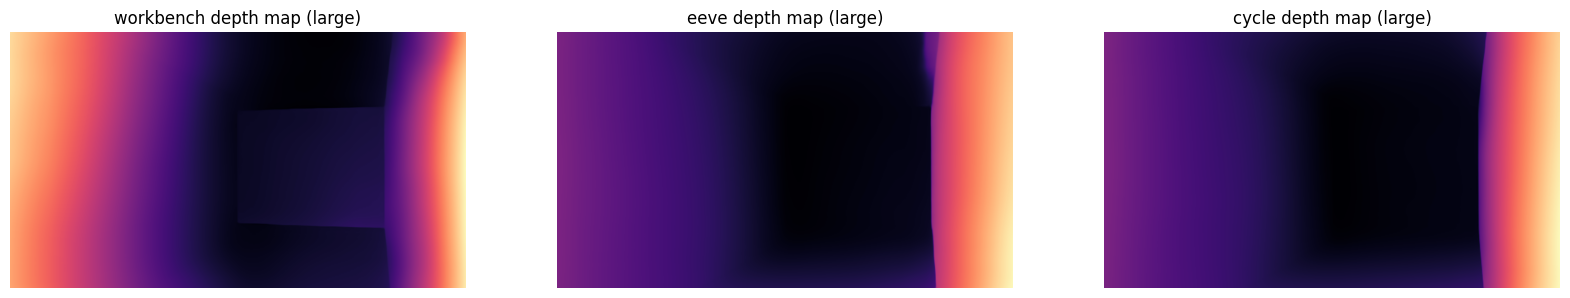

In [35]:
plt.figure(figsize = (20,20))

plt.subplot(1,3,1)
plt.imshow(depth_map_workbench_large)
plt.title("workbench depth map (large)")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(depth_map_eeve_large)
plt.title("eeve depth map (large)")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(depth_map_cycle_large)
plt.title("cycle depth map (large)")
plt.axis("off")


##6.3 Plotting predctions for small midas model

In [38]:
depth_map_workbench_small = cv.cvtColor(depth_map_workbench_small, cv.COLOR_BGR2RGB)
depth_map_eeve_small = cv.cvtColor(depth_map_eeve_small, cv.COLOR_BGR2RGB)
depth_map_cycle_small = cv.cvtColor(depth_map_cycle_small, cv.COLOR_BGR2RGB)

(-0.5, 1919.5, 1079.5, -0.5)

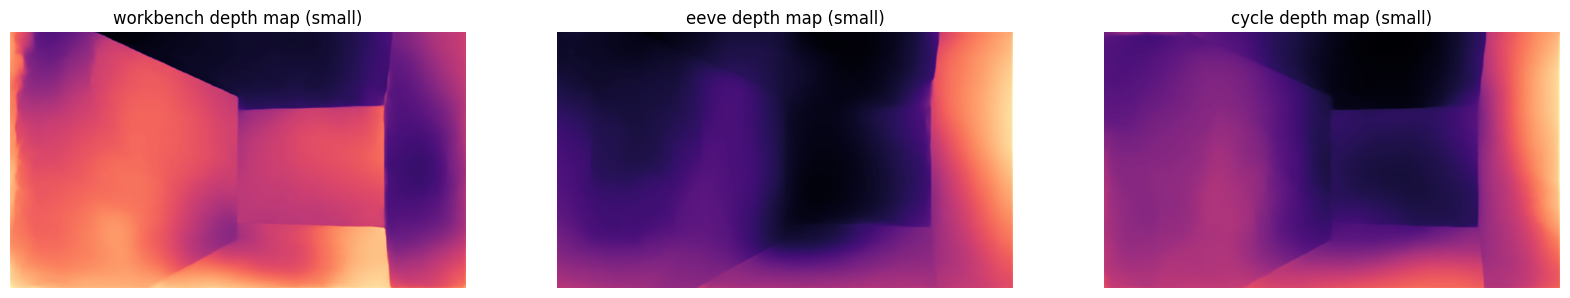

In [39]:
plt.figure(figsize = (20,20))

plt.subplot(1,3,1)
plt.imshow(depth_map_workbench_small)
plt.title("workbench depth map (small)")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(depth_map_eeve_small)
plt.title("eeve depth map (small)")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(depth_map_cycle_small)
plt.title("cycle depth map (small)")
plt.axis("off")


In [40]:
depth_map_cycle_large.shape , depth_map_cycle_data_large.shape #initial size remains the sample for both the large and small model

((1080, 1920, 3), (1080, 1920))

##6.4 Cropping predictions

###6.4.1 Cropping large model predictions

In [42]:
workbench_depth_squeezed_large = depth_map_workbench_large[ 600 : 900 ,  0 : size[1] ] #Cropping
eeve_depth_squeezed_large = depth_map_eeve_large[ 600 : 900 ,  0 : size[1] ]
cycle_depth_squeezed_large = depth_map_cycle_large[ 600 : 900,  0 : size[1] ]

depth_map_workbench_data_large = depth_map_workbench_data_large[ 600 : 900 ,  0 : size[1] ]
depth_map_eeve_data_large = depth_map_eeve_data_large[ 600 : 900 ,  0 : size[1] ]
depth_map_cycle_data_large = depth_map_cycle_data_large[ 600 : 900 ,  0 : size[1] ]

###6.4.2 Cropping small model predictions

In [44]:
workbench_depth_squeezed_small = depth_map_workbench_small[ 600 : 900 ,  0 : size[1] ] #Cropping
eeve_depth_squeezed_small = depth_map_eeve_small[ 600 : 900 ,  0 : size[1] ]
cycle_depth_squeezed_small = depth_map_cycle_small[ 600 : 900,  0 : size[1] ]

depth_map_workbench_data_small = depth_map_workbench_data_small[ 600 : 900 ,  0 : size[1] ]
depth_map_eeve_data_small = depth_map_eeve_data_small[ 600 : 900 ,  0 : size[1] ]
depth_map_cycle_data_small = depth_map_cycle_data_small[ 600 : 900 ,  0 : size[1] ]

In [45]:
depth_map_workbench_data_large , depth_map_workbench_data_small

(array([[0.86420024, 0.86419041, 0.86436381, ..., 0.99549389, 0.99795091,
         0.99905341],
        [0.86389453, 0.86388506, 0.86405979, ..., 0.99547927, 0.99794719,
         0.99905401],
        [0.86366912, 0.86365977, 0.86383485, ..., 0.99547364, 0.99795247,
         0.99906323],
        ...,
        [0.81298975, 0.81302906, 0.81336155, ..., 0.97692886, 0.97975977,
         0.9810171 ],
        [0.81296848, 0.81300725, 0.81333788, ..., 0.97673628, 0.97957534,
         0.98083543],
        [0.81296363, 0.81299862, 0.81331894, ..., 0.97653783, 0.97939187,
         0.98065783]]),
 array([], shape=(0, 1920), dtype=float64))

In [46]:
depth_map_eeve_data_large , depth_map_eeve_data_small

(array([[0.36466731, 0.36466763, 0.36474194, ..., 0.93229256, 0.93378255,
         0.93441483],
        [0.36466174, 0.36466214, 0.36473674, ..., 0.9324267 , 0.93392724,
         0.93456366],
        [0.36465672, 0.36465712, 0.36473179, ..., 0.93252418, 0.93403329,
         0.93467307],
        ...,
        [0.36146088, 0.3614515 , 0.36150286, ..., 0.97835973, 0.97985663,
         0.98049851],
        [0.36149533, 0.36148456, 0.36153174, ..., 0.97842025, 0.97992406,
         0.9805687 ],
        [0.36153879, 0.36152519, 0.36156458, ..., 0.97849976, 0.98001266,
         0.98066072]]),
 array([], shape=(0, 1920), dtype=float64))

In [47]:
cycle_depth_squeezed_large.shape , depth_map_cycle_data_large.shape

((300, 1920, 3), (300, 1920))

###6.4.4 Plotting large model predictions

(-0.5, 1919.5, 299.5, -0.5)

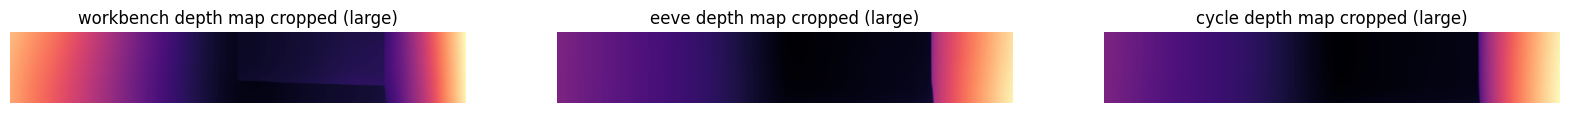

In [49]:
plt.figure(figsize = (20,20))

plt.subplot(1,3,1)
plt.imshow(workbench_depth_squeezed_large)
plt.title("workbench depth map cropped (large)")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(eeve_depth_squeezed_large)
plt.title("eeve depth map cropped (large)")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(cycle_depth_squeezed_large)
plt.title("cycle depth map cropped (large)")
plt.axis("off")


###6.4.5 Plotting small model predictions

(-0.5, 1919.5, 299.5, -0.5)

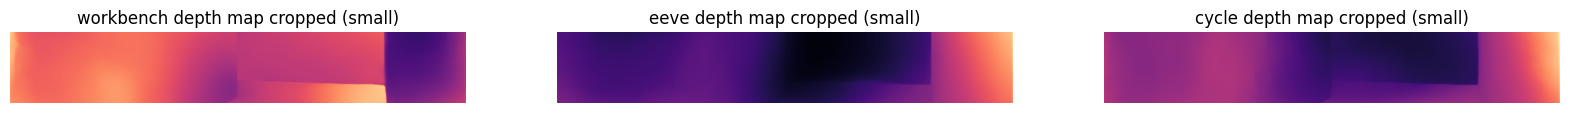

In [50]:
plt.figure(figsize = (20,20))

plt.subplot(1,3,1)
plt.imshow(workbench_depth_squeezed_small)
plt.title("workbench depth map cropped (small)")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(eeve_depth_squeezed_small)
plt.title("eeve depth map cropped (small)")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(cycle_depth_squeezed_small)
plt.title("cycle depth map cropped (small)")
plt.axis("off")


In [53]:
size_squeezed = workbench_depth_squeezed_large.shape #will be the same for small and large model as well as all the three test images
size_squeezed

(300, 1920, 3)

#7 Segmentation

In [54]:
def segments(amount : int , width : int) -> list[tuple[int]]:

  slice_list = []
  amount = 10

  sections = width // amount

  beg = sections
  temp = 0
  for batches in range(amount):
    section = sections + temp

    if batches == 0:
      # print( 0 , section)
      slice_list.append((0 , sections))
    else:
      # print(beg , beg + sections)
      slice_list.append((beg , beg + sections))
      beg += sections

  return slice_list

In [55]:
seg = segments(amount = 10 , width = size_squeezed[1])
seg

[(0, 192),
 (192, 384),
 (384, 576),
 (576, 768),
 (768, 960),
 (960, 1152),
 (1152, 1344),
 (1344, 1536),
 (1536, 1728),
 (1728, 1920)]

In [56]:
depth_map_workbench_data_large.shape , depth_map_eeve_data_large.shape , depth_map_cycle_data_large.shape

((300, 1920), (300, 1920), (300, 1920))

In [57]:
depth_map_workbench_data_small.shape , depth_map_eeve_data_small.shape , depth_map_cycle_data_small.shape

((0, 1920), (0, 1920), (0, 1920))

brightest points workbench large {1: 0.86, 2: 0.7, 3: 0.51, 4: 0.31, 5: 0.15, 6: 0.11, 7: 0.15, 8: 0.17, 9: 0.52, 10: 1.0}
brightest points eeve large {1: 1.0, 2: 0.37, 3: 0.29, 4: 0.22, 5: 0.18, 6: 0.11, 7: 0.04, 8: 0.05, 9: 0.06, 10: 0.69}
brightest points cycle large {1: 0.37, 2: 0.29, 3: 0.22, 4: 0.18, 5: 0.11, 6: 0.04, 7: 0.05, 8: 0.06, 9: 0.69, 10: 1.0}


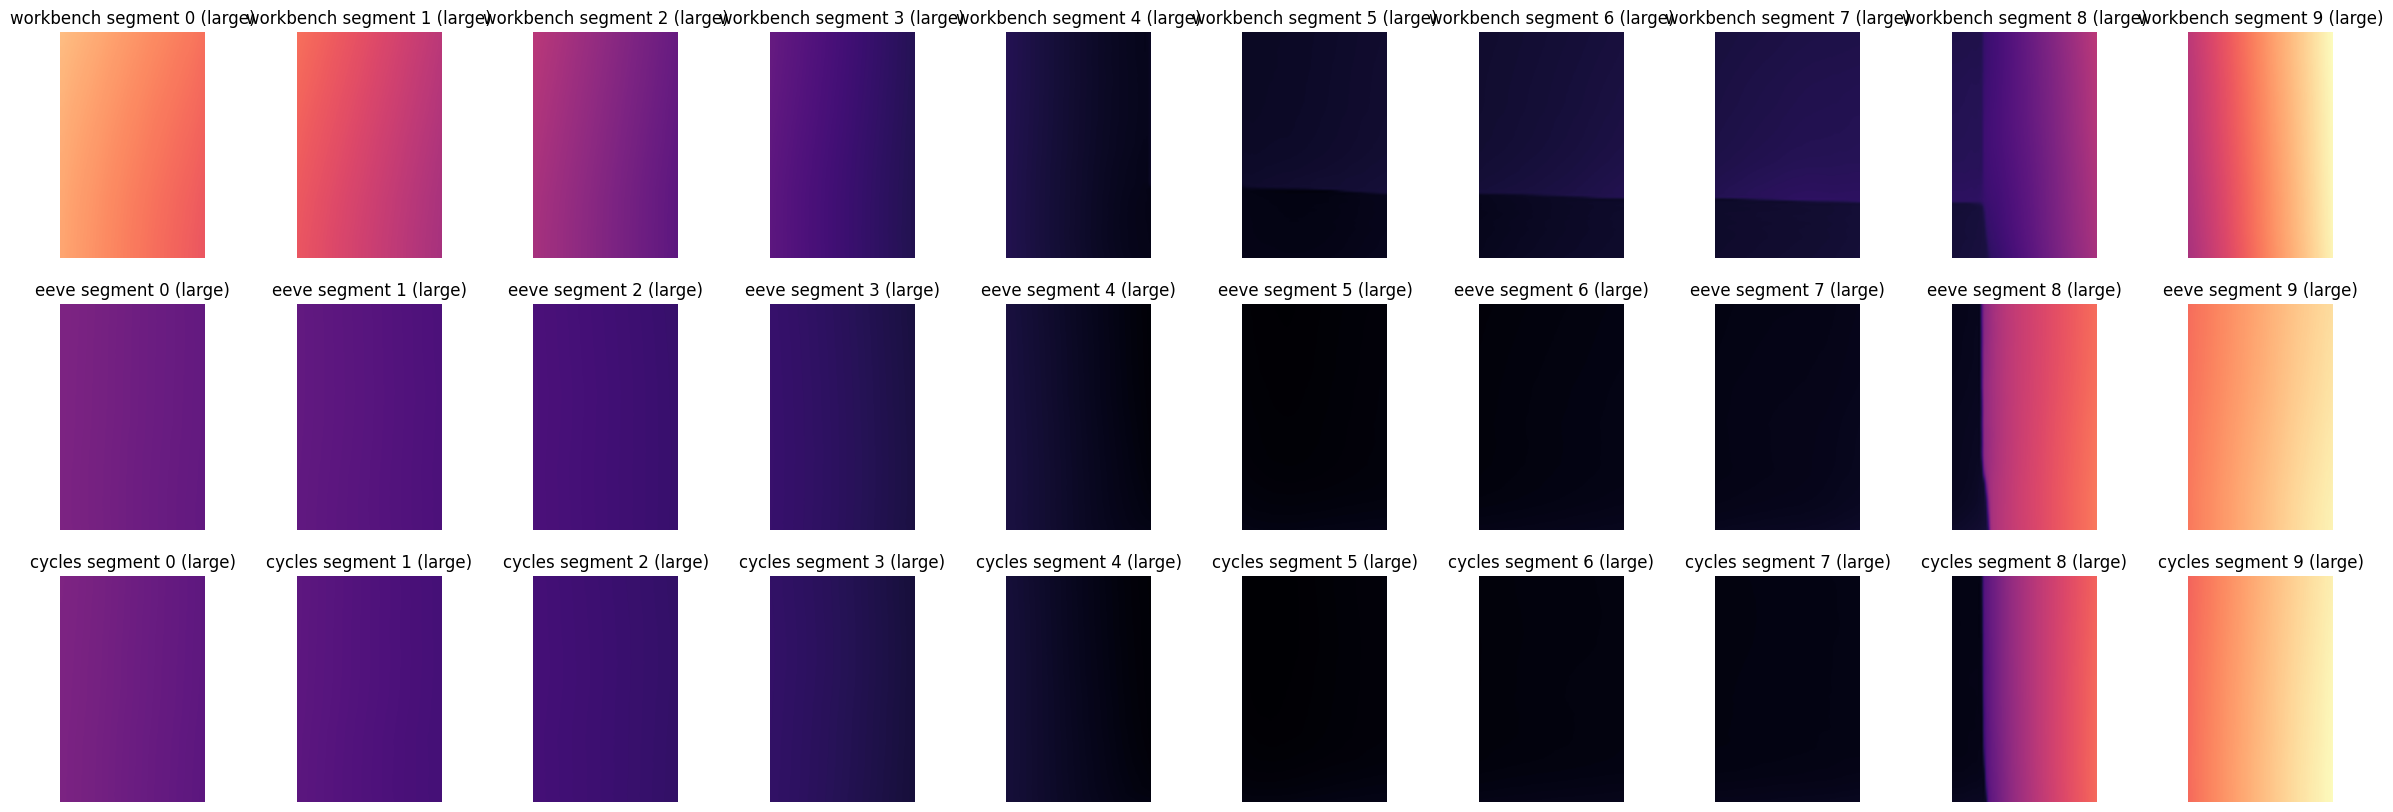

In [100]:
brightest_points_cycles_large = {}
brightest_points_eeve_large = {}
brightest_points_workbench_large = {}

plt.figure(figsize = (30,10))

for segments in range(len(seg)):
  plt.subplot(3 , len(seg) , segments + 1)
  cropped_workbench = workbench_depth_squeezed_large[0 : size_squeezed[0] , seg[0+segments][0] : seg[0+segments][1] ]
  cropped_data_workbench = depth_map_workbench_data_large[0 : size_squeezed[0] , seg[0+segments][0] : seg[0+segments][1] ]
  brightest_point_workbench = np.max(cropped_data_workbench)
  brightest_points_workbench_large[segments + 1] = round(brightest_point_workbench  , 2)
  plt.title(f"workbench segment {segments} (large)")
  plt.imshow(cropped_workbench)
  plt.axis("off")

  plt.subplot(3 , len(seg) , segments + 1 + len(seg))
  cropped_eeve = eeve_depth_squeezed_large[0 : size_squeezed[0] , seg[0+segments][0] : seg[0+segments][1] ]
  cropped_data_eeve = depth_map_cycle_data_large[0 : size_squeezed[0] , seg[0+segments][0] : seg[0+segments][1] ]
  brightest_point_eeve = np.max(cropped_data_cycle)
  brightest_points_eeve_large[segments + 1] = round(brightest_point_cycle  , 2)
  plt.title(f"eeve segment {segments} (large)")
  plt.imshow(cropped_eeve)
  plt.axis("off")

  plt.subplot(3 , len(seg) , segments + 1 + len(seg) + len(seg))
  cropped_cycle = cycle_depth_squeezed_large[0 : size_squeezed[0] , seg[0+segments][0] : seg[0+segments][1] ]
  cropped_data_cycle = depth_map_cycle_data_large[0 : size_squeezed[0] , seg[0+segments][0] : seg[0+segments][1] ]
  brightest_point_cycle = np.max(cropped_data_cycle)
  brightest_points_cycles_large[segments + 1] = round(brightest_point_cycle  , 2)
  plt.title(f"cycles segment {segments} (large)")
  plt.imshow(cropped_cycle)
  plt.axis("off")

print(f"brightest points workbench large {brightest_points_workbench_large}")
print(f"brightest points eeve large {brightest_points_eeve_large}")
print(f"brightest points cycle large {brightest_points_cycles_large}")


brightest points workbench small {1: 0.86, 2: 0.7, 3: 0.51, 4: 0.31, 5: 0.15, 6: 0.11, 7: 0.15, 8: 0.17, 9: 0.52, 10: 1.0}
brightest points eeve small {1: 1.0, 2: 0.37, 3: 0.29, 4: 0.22, 5: 0.18, 6: 0.11, 7: 0.04, 8: 0.05, 9: 0.06, 10: 0.69}
brightest points cycle small {1: 0.37, 2: 0.29, 3: 0.22, 4: 0.18, 5: 0.11, 6: 0.04, 7: 0.05, 8: 0.06, 9: 0.69, 10: 1.0}


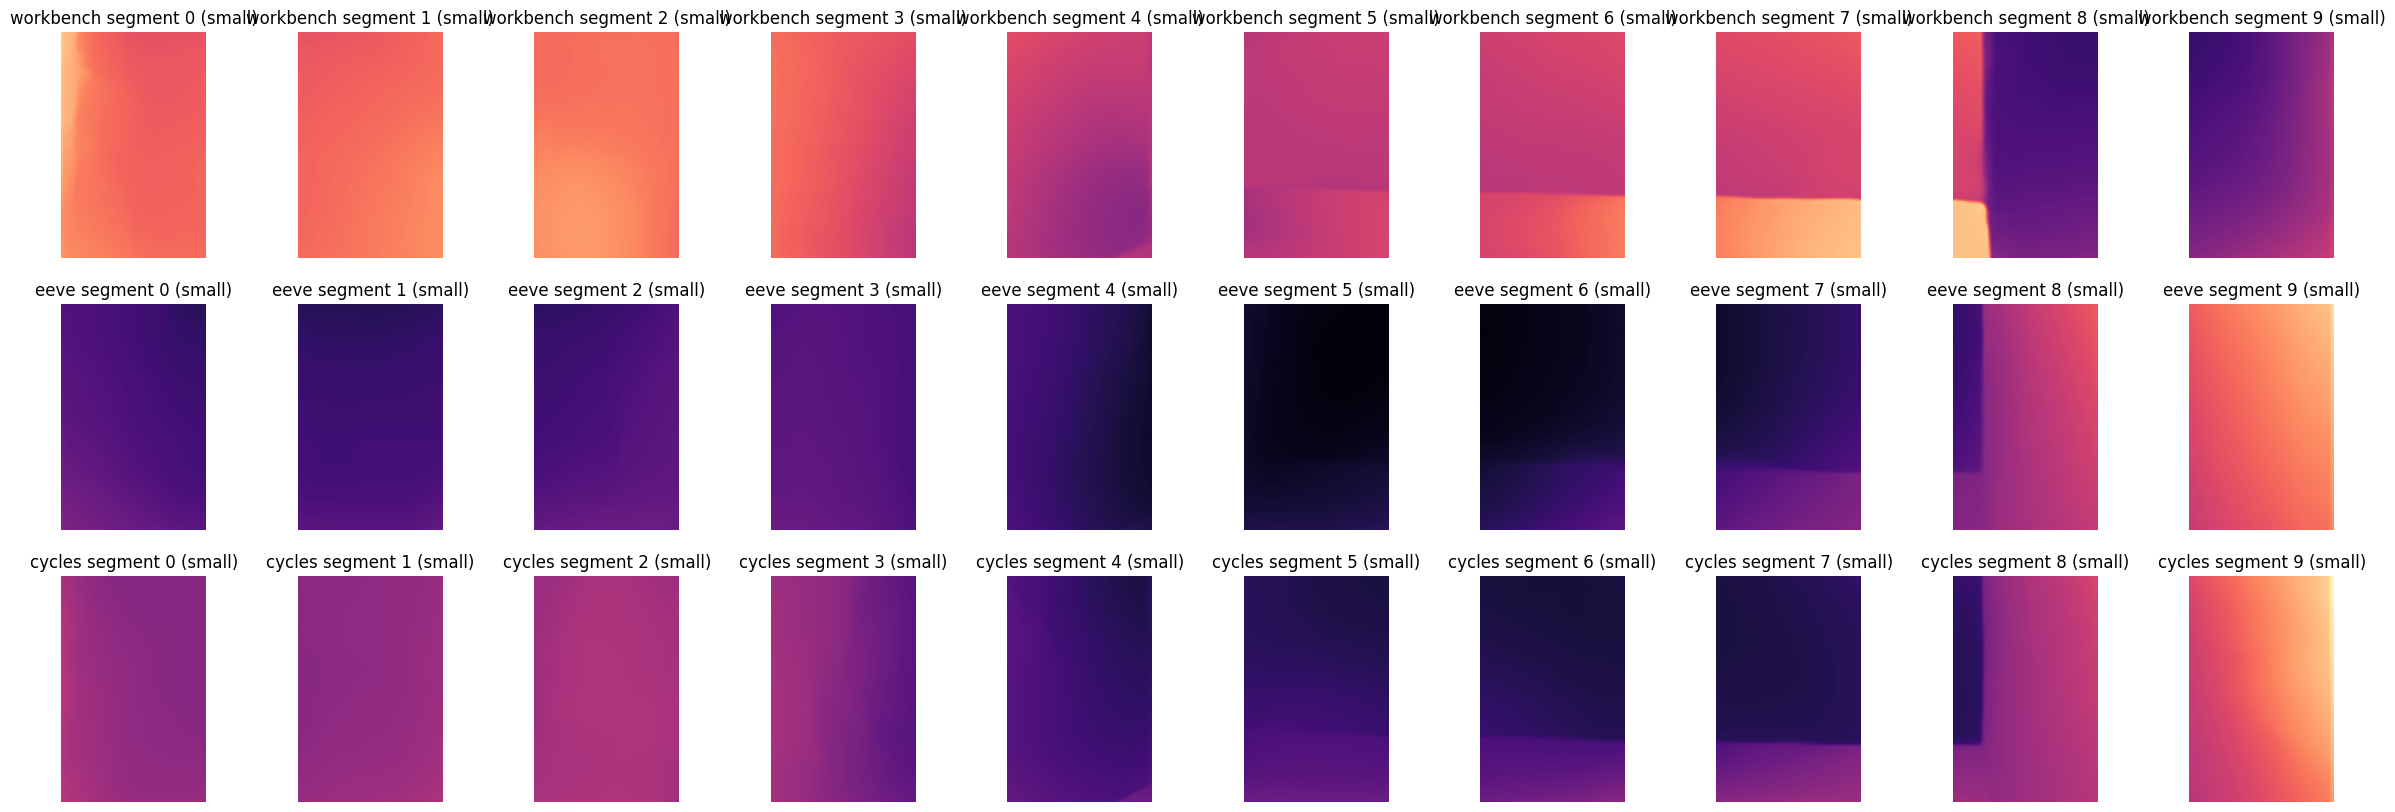

In [101]:
brightest_points_cycles_small = {}
brightest_points_eeve_small = {}
brightest_points_workbench_small = {}

plt.figure(figsize = (30,10))

for segments in range(len(seg)):
  plt.subplot(3 , len(seg) , segments + 1)
  cropped_workbench = workbench_depth_squeezed_small[0 : size_squeezed[0] , seg[0+segments][0] : seg[0+segments][1] ]
  cropped_data_workbench = depth_map_workbench_data_small[0 : size_squeezed[0] , seg[0+segments][0] : seg[0+segments][1] ]
  brightest_point_workbench = np.max(cropped_data_workbench)
  brightest_points_workbench_small[segments + 1] = round(brightest_point_workbench  , 2)
  plt.title(f"workbench segment {segments} (small)")
  plt.imshow(cropped_workbench)
  plt.axis("off")

  plt.subplot(3 , len(seg) , segments + 1 + len(seg))
  cropped_eeve = eeve_depth_squeezed_small[0 : size_squeezed[0] , seg[0+segments][0] : seg[0+segments][1] ]
  cropped_data_eeve = depth_map_cycle_data_small[0 : size_squeezed[0] , seg[0+segments][0] : seg[0+segments][1] ]
  brightest_point_eeve = np.max(cropped_data_cycle)
  brightest_points_eeve_small[segments + 1] = round(brightest_point_cycle  , 2)
  plt.title(f"eeve segment {segments} (small)")
  plt.imshow(cropped_eeve)
  plt.axis("off")

  plt.subplot(3 , len(seg) , segments + 1 + len(seg) + len(seg))
  cropped_cycle = cycle_depth_squeezed_small[0 : size_squeezed[0] , seg[0+segments][0] : seg[0+segments][1] ]
  cropped_data_cycle = depth_map_cycle_data_small[0 : size_squeezed[0] , seg[0+segments][0] : seg[0+segments][1] ]
  brightest_point_cycle = np.max(cropped_data_cycle)
  brightest_points_cycles_small[segments + 1] = round(brightest_point_cycle  , 2)
  plt.title(f"cycles segment {segments} (small)")
  plt.imshow(cropped_cycle)
  plt.axis("off")

print(f"brightest points workbench small {brightest_points_workbench_large}")
print(f"brightest points eeve small {brightest_points_eeve_large}")
print(f"brightest points cycle small {brightest_points_cycles_large}")


In [103]:
brightest_points_workbench_large , brightest_points_eeve_large , brightest_points_cycles_large

({1: 0.86,
  2: 0.7,
  3: 0.51,
  4: 0.31,
  5: 0.15,
  6: 0.11,
  7: 0.15,
  8: 0.17,
  9: 0.52,
  10: 1.0},
 {1: 1.0,
  2: 0.37,
  3: 0.29,
  4: 0.22,
  5: 0.18,
  6: 0.11,
  7: 0.04,
  8: 0.05,
  9: 0.06,
  10: 0.69},
 {1: 0.37,
  2: 0.29,
  3: 0.22,
  4: 0.18,
  5: 0.11,
  6: 0.04,
  7: 0.05,
  8: 0.06,
  9: 0.69,
  10: 1.0})

In [104]:
brightest_points_workbench_small , brightest_points_eeve_small , brightest_points_cycles_small

({1: 0.82,
  2: 0.6,
  3: 0.67,
  4: 0.67,
  5: 0.62,
  6: 0.38,
  7: 0.16,
  8: 0.25,
  9: 0.45,
  10: 0.58},
 {1: 1.0,
  2: 0.48,
  3: 0.43,
  4: 0.38,
  5: 0.37,
  6: 0.24,
  7: 0.09,
  8: 0.05,
  9: 0.21,
  10: 0.69},
 {1: 0.48,
  2: 0.43,
  3: 0.38,
  4: 0.37,
  5: 0.24,
  6: 0.09,
  7: 0.05,
  8: 0.21,
  9: 0.69,
  10: 1.0})

In [107]:
brightest_points_workbench_normal_large = {}
for i in range(1 , len(brightest_points_workbench_large) + 1 ):
  brightest_points_workbench_normal_large[i] = round(1 - brightest_points_workbench_large[i] , 2)

brightest_points_eeve_normal_large = {}
for i in range(1 , len(brightest_points_eeve_large) + 1 ):
  brightest_points_eeve_normal_large[i] = round(1 - brightest_points_eeve_large[i] , 2)

brightest_points_cycle_normal_large = {}
for i in range(1 , len(brightest_points_cycles_large) + 1 ):
  brightest_points_cycle_normal_large[i] = round(1 - brightest_points_cycles_large[i] , 2)

In [108]:
brightest_points_workbench_normal_small = {}
for i in range(1 , len(brightest_points_workbench_small) + 1 ):
  brightest_points_workbench_normal_small[i] = round(1 - brightest_points_workbench_small[i] , 2)

brightest_points_eeve_normal_small = {}
for i in range(1 , len(brightest_points_eeve_small) + 1 ):
  brightest_points_eeve_normal_small[i] = round(1 - brightest_points_eeve_small[i] , 2)

brightest_points_cycle_normal_small = {}
for i in range(1 , len(brightest_points_cycles_small) + 1 ):
  brightest_points_cycle_normal_small[i] = round(1 - brightest_points_cycles_small[i] , 2)

In [109]:
brightest_points_workbench_normal_large , brightest_points_eeve_normal_large , brightest_points_cycle_normal_large

({1: 0.14,
  2: 0.3,
  3: 0.49,
  4: 0.69,
  5: 0.85,
  6: 0.89,
  7: 0.85,
  8: 0.83,
  9: 0.48,
  10: 0.0},
 {1: 0.0,
  2: 0.63,
  3: 0.71,
  4: 0.78,
  5: 0.82,
  6: 0.89,
  7: 0.96,
  8: 0.95,
  9: 0.94,
  10: 0.31},
 {1: 0.63,
  2: 0.71,
  3: 0.78,
  4: 0.82,
  5: 0.89,
  6: 0.96,
  7: 0.95,
  8: 0.94,
  9: 0.31,
  10: 0.0})

In [110]:
brightest_points_workbench_normal_small , brightest_points_eeve_normal_small , brightest_points_cycle_normal_small

({1: 0.18,
  2: 0.4,
  3: 0.33,
  4: 0.33,
  5: 0.38,
  6: 0.62,
  7: 0.84,
  8: 0.75,
  9: 0.55,
  10: 0.42},
 {1: 0.0,
  2: 0.52,
  3: 0.57,
  4: 0.62,
  5: 0.63,
  6: 0.76,
  7: 0.91,
  8: 0.95,
  9: 0.79,
  10: 0.31},
 {1: 0.52,
  2: 0.57,
  3: 0.62,
  4: 0.63,
  5: 0.76,
  6: 0.91,
  7: 0.95,
  8: 0.79,
  9: 0.31,
  10: 0.0})

#8 Plotting polar (proximity) graph

In [126]:
def polar_plot(brightest_points : dict , title : str , marker , rotation = 0):
  ax = plt.subplot(111 , projection = "polar")
  ax.set_rmax(1)
  ax.set_rlabel_position(0)
  degrees= 360/len(brightest_points)
  theta=np.deg2rad(np.arange(0 + rotation ,361 + rotation ,degrees))[1:]
  theta = np.append(theta , theta[0])
  brightest_points[len(brightest_points)+1] = list(brightest_points.values())[0]
  ax.plot(theta , brightest_points.values() , marker = marker)
  plt.title(title)

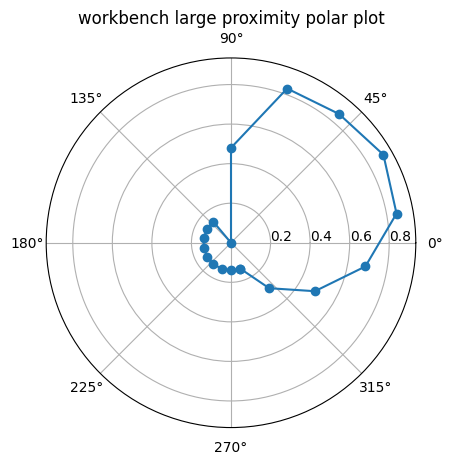

In [133]:
polar_plot(brightest_points_workbench_normal_large , title = "workbench large proximity polar plot" , marker = "o" , rotation = -90) #closest proximity value is lower

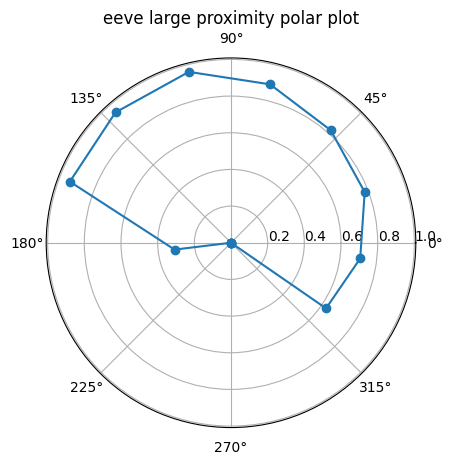

In [134]:
polar_plot(brightest_points_eeve_normal_large , title = "eeve large proximity polar plot" , marker = "o", rotation = -90)  #closest proximity value is lower

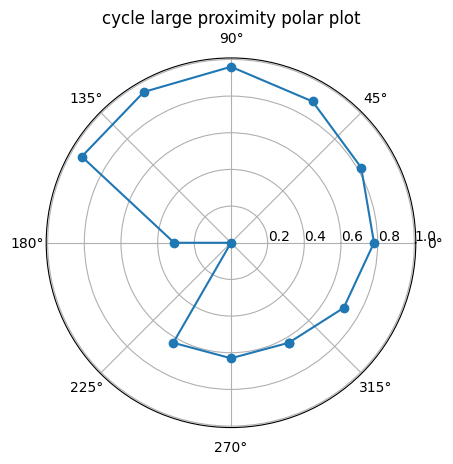

In [135]:
polar_plot(brightest_points_cycle_normal_large , title = "cycles large proximity polar plot" , marker = "o" , rotation = -90) #closest proximity value is lower

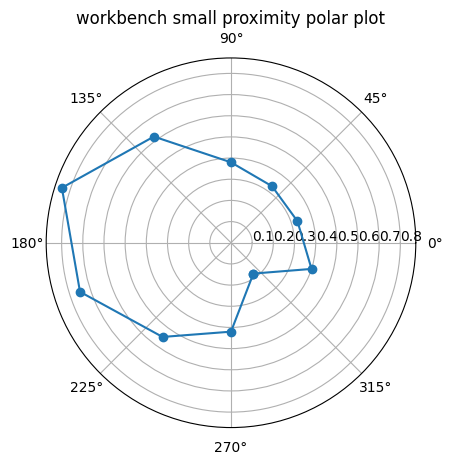

In [136]:
polar_plot(brightest_points_workbench_normal_small , title = "workbench small proximity polar plot" , marker = "o" , rotation = -90) #closest proximity value is lower

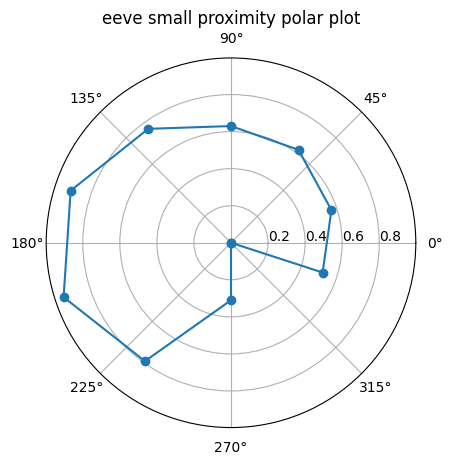

In [137]:
polar_plot(brightest_points_eeve_normal_small , title = "eeve small proximity polar plot" , marker = "o" , rotation = -90) #closest proximity value is lower

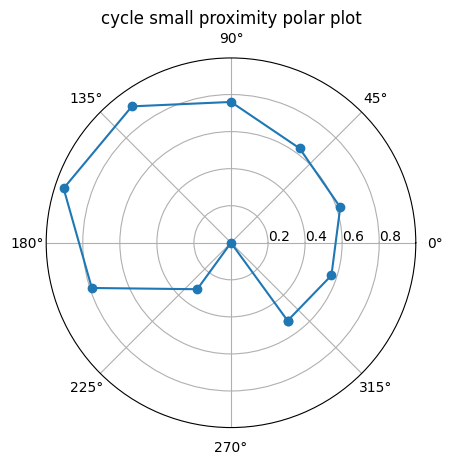

In [138]:
polar_plot(brightest_points_cycle_normal_small , title = "cycles small proximity polar plot" , marker = "o" , rotation = -90) #closest proximity value is lower